# U-net as a Classifier

Treat U-net as a classification algorithm. If an image from the dataset contains at least one ship, then it is a positive observation. Otherwise, it is a negative observation.

If the output of U-net contains a number of pixels that is greater than or equal to a specified threshold, then it is classified as positive. Otherwise, it is classified as negative.

## Construct the Test Set

The test set contains the 6556 images with ships (positive) that were not used for training, as well as another 6556 randomly selected images that do not contain any ships (negative).

In [1]:
import os
import pathlib
import pandas as pd
import random
from fastai.vision.all import *
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# path to the airbus dataset
airbus_path = pathlib.Path('../airbus_dataset/').resolve()

# get all images with ships
masks_rle = pd.read_csv('../airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()

# get the images with ships that were not used for training
train_valid = [f for f in os.listdir(airbus_path/'train_valid')]
ship_images_not_train = list(set(ship_images) - set(train_valid))

print('Number of images with ships:', len(ship_images))
print('Number of images with ships used for training:', len(train_valid))
print('Number of images with ships not used for training:', len(ship_images_not_train))

# get images without ships
all_images = [f for f in os.listdir(airbus_path/'train_v2')]
no_ship_images = list(set(all_images) - set(ship_images))

print()
print('Number of images in the entire Airbus dataset:', len(all_images))
print('Number of images without any ships:', len(no_ship_images))

# randomly select 6556 images without ships
no_ship_images = random.sample(no_ship_images, 6556)
print()
print('Number of randomly selected no ship images:', len(no_ship_images))

# construct the final test set
test_set = list(set(ship_images_not_train).union(set(no_ship_images)))
print()
print('Number of classifier test images:', len(test_set))


Number of images with ships: 42556
Number of images with ships used for training: 36000
Number of images with ships not used for training: 6556

Number of images in the entire Airbus dataset: 192556
Number of images without any ships: 150000

Number of randomly selected no ship images: 6556

Number of classifier test images: 13112


## U-net Predictions

Generate the predictions of U-net for the images in the classifier test set.

### Load the Pre-trained Model

We first need to create the architecture the same way we did for training, then load the model from *models/unet_googlenet.pth*.

/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


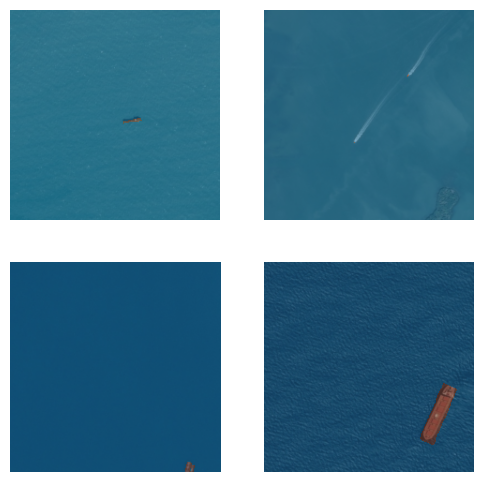

In [3]:
# define a function that gets the label for a given image
def label_func(fn): return airbus_path/"train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(airbus_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224) # resize images to 224x224
)

# load the data in the datablock
dls = dblock.dataloaders(airbus_path/'train_valid/', bs=4)

dls.show_batch(max_n=4)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet.load('unet_googlenet')

### Generate the Predictions

1. Perform inference on the original image using U-net
2. Threshold the image at 0: pixel values greater than 0 will be 1, and less than 0 will be 0
3. Count the number of non-zero pixels (ship pixels)
4. Determine the label of the image based on the number of ship pixel
    * At least 1 ship pixel -> True
    * 0 ship pixels -> False

376fcd2d3.jpg


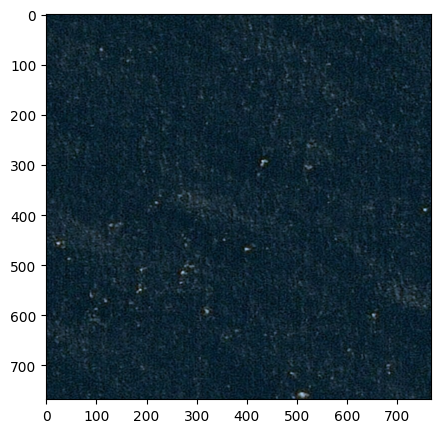

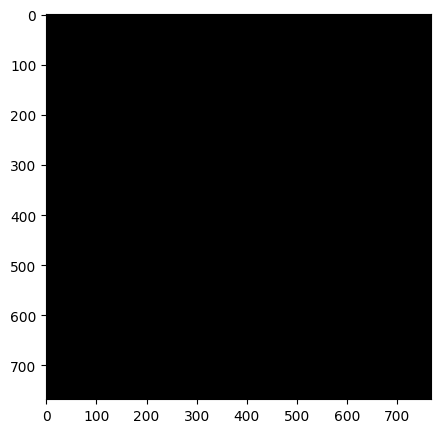

Predicted label: True


In [4]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    #
    # need to check if the image has at least a ship
    if image_id in ship_images:
        for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
            mask = mask.split()
            mask = [int(i) for i in mask]
            for i in range(0, len(mask), 2):
                image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

# determine the class of an image (True or False)
def get_class_label(image_id):

    # perform inference on the image
    with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(airbus_path/'train_v2'/image_id)
    pred = pred.numpy()[1]

    # threshold the image at 0
    pred[(pred > 0)] = 1
    pred[(pred < 0)] = 0

    # plt.imshow(pred, cmap='Greys_r')
    # plt.show()

    # determine the number of pixels identified as ship (pixel value = 1)
    ship_pixels = np.count_nonzero(pred)
    # print(ship_pixels)

    # determine the class of the image based on the number of ship pixels within it
    if ship_pixels > 0:
        return True
    else:
        return False

# load an image
img_id = test_set[7000]
img = np.array(Image.open('../airbus_dataset/train_v2/' + img_id))

# load the image mask
img_mask = np.array(Image.fromarray(get_image_mask(img_id)))

# display the image
print(img_id)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(img_mask, cmap='Greys_r')
plt.show()

# predict the label of the image
print('Predicted label:', get_class_label(img_id))

### Calculate the Accuracy

1. Determine the label of each test image
2. Check if the prediction is correct:
    * label = True and image is in *ship_images* (contains at least one ship)
    * label = False and image is not in *ship_images* (does not contain any ships)

In [8]:
# loop through all the images in the test set
tp = 0
tn = 0
for im in test_set:
    
    # get the predicted class of the image
    pred_class = get_class_label(im)

    # check if the prediction is correct
    if im in ship_images and pred_class == True:
        tp += 1
    elif im not in ship_images and pred_class == False:
        tn += 1

print('True Positives:', tp)
print('True Negatives:', tn)
print('Accuracy:', (tp + tn) / len(test_set))

True Positives: 6013
True Negatives: 6219
Accuracy: 0.9328859060402684
